In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

from typing import List
import os
from pathlib import Path

from tqdm import tqdm
import itertools

import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in log10*")

In [3]:
nonres_scan_cuts = ["txbb", "bdt", "lepton_veto"]
res_scan_cuts = ["txbb", "thww", "leadingpt", "subleadingpt"]
scan_labels = {
    "txbb": r"$T_{Xbb}$ WP",
    "thww": r"$T_{HWW}$ WP",
    "bdt": "BDT",
    "lepton_veto": "Lepton Veto",
    "leadingpt": r"Leading jet $p_T$ (GeV)",
    "subleadingpt": r"Sub-leading jet $p_T$ (GeV)",
}

# scan_txbb_wps = ["LP", "MP", "HP"]
# scan_bdt_wps = [0.6, 0.9, 0.96, 0.99, 0.997, 0.998, 0.999]

scan_txbb_wps = ["MP", "HP"]
scan_bdt_wps = [0.99, 0.997, 0.998, 0.999, 0.9997, 0.9999]

scan_lepton_veto = ["Hbb"]
scan_thww_wps = [0.4, 0.6, 0.8, 0.9, 0.94, 0.96, 0.98]
scan_leadingpt_wps = [300.0, 350.0, 400.0, 450.0]
scan_subleadingpt_wps = [300.0, 350.0, 400.0, 450.0]

plot_dir = Path("../../../../plots/Scans/24Apr4VBFBDTScan")
plot_dir.mkdir(parents=True, exist_ok=True)


# nonresonat
cards_dir = Path("/uscms/home/rkansal/hhcombine/cards/24Apr4VBFBDTScan/")
# cards_dir = "/uscms/home/rkansal/hhcombine/cards/23May14NonresScan/"

# resonant
# cards_dir = "/uscms/home/rkansal/hhcombine/eoscards/23Sep12_res_pt_scan/"
# cards_dir = "/uscms/home/rkansal/hhcombine/eoscards/23May1Scan/"

In [5]:
resonant = False
pt_scan = False

if resonant:
    if pt_scan:
        scan_txbb_wps = ["HP"]
        scan_thww_wps = [0.6, 0.8]
        scan_wps = list(
            itertools.product(
                scan_txbb_wps, scan_thww_wps, scan_leadingpt_wps, scan_subleadingpt_wps
            )
        )
        # remove WPs where subleading pT > leading pT
        scan_wps = [wp for wp in scan_wps if wp[3] <= wp[2]]
        scan1_wps, scan2_wps = scan_leadingpt_wps, scan_subleadingpt_wps
        scan_cuts = res_scan_cuts
    else:
        scan_wps = list(itertools.product(scan_txbb_wps, scan_thww_wps))
        scan1_wps, scan2_wps = scan_txbb_wps, scan_thww_wps
        scan_cuts = res_scan_cuts[:2]

    res_mps = [
        (900, 80),
        (1200, 190),
        (2000, 125),
        (3000, 250),
        (4000, 150),
    ]

    scan_samples = []

    for mX, mY in res_mps:
        scan_samples.append(f"NMSSM_XToYHTo2W2BTo4Q2B_MX-{mX}_MY-{mY}")
else:
    scan_wps = list(itertools.product(scan_txbb_wps, scan_bdt_wps))
    scan1_wps, scan2_wps = scan_txbb_wps, scan_bdt_wps
    scan_cuts = nonres_scan_cuts
    scan_samples = ["SM", "k2v0"]
    scan_samples = ["k2v0"]

In [ ]:
def mxmy(sample):
    mY = int(sample.split("-")[-1])
    mX = int(sample.split("NMSSM_XToYHTo2W2BTo4Q2B_MX-")[1].split("_")[0])

    return (mX, mY)

In [6]:
limits = {}
extrastr = "_lepton_veto_Hbb" if not resonant else ""

# parse limits
for sample in tqdm(scan_samples):
    limits[sample] = {" 2.5": [], "16.0": [], "50.0": [], "84.0": [], "97.5": []}

    for wps in scan_wps:
        cutstr = "_".join([f"{cut}_{wp}" for cut, wp in zip(scan_cuts, wps)])
        cutstr += extrastr
        if not resonant:
            limits_path = cards_dir / sample / cutstr / "outs/AsymptoticLimits.txt"
        else:
            limits_path = cards_dir / cutstr / sample / "AsymptoticLimits.txt"

        if os.path.exists(limits_path):
            with open(limits_path, "r") as f:
                lines = f.readlines()

            nums = 0
            for i in np.arange(len(lines) - 1, -1, -1):
                line = lines[i][:-1]
                for key in limits[sample]:
                    start_str = f"Expected {key}%: r < "
                    if line.startswith(start_str):
                        limits[sample][key].append([*wps, float(line.split(start_str)[1])])
                        nums += 1

                if nums == 5:
                    break

            if nums != 5:
                print(f"{cutstr}/{sample} Limits not found!")
        else:
            print(f"{limits_path} doesn't exist!")

100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


In [10]:
def plot_limits(ax, lim, sample, plt_thww_wp=0.8):
    # convert to image
    im = np.zeros((len(scan1_wps), len(scan2_wps)))

    if pt_scan:
        plt_scan_cuts = scan_cuts[2:]
        for _, thww_wp, wp1, wp2, l in lim:
            if thww_wp == plt_thww_wp:
                im[scan1_wps.index(wp1), scan2_wps.index(float(wp2))] = l
    else:
        plt_scan_cuts = scan_cuts
        for wp1, wp2, l in lim:
            im[scan1_wps.index(wp1), scan2_wps.index(float(wp2))] = l

    im = im[::-1]

    im = ax.imshow(im, cmap="turbo")
    if resonant:
        plt.colorbar(im, ax=ax, label="Expected exclusion limit (fb)")
    else:
        if sample == "SM":
            plt.colorbar(im, ax=ax, label=r"Expected exclusion limit $\times$SM")
        else:
            plt.colorbar(im, ax=ax, label=r"Expected exclusion limit $\times$ theory")

    for vals in lim:
        if pt_scan:
            _, thww_wp, wp1, wp2, l = vals
            if thww_wp != plt_thww_wp:
                continue
        else:
            wp1, wp2, l = vals
        ax.text(
            scan2_wps.index(float(wp2)),
            len(scan1_wps) - scan1_wps.index(wp1) - 1,
            f"{l:.2f}",
            fontsize=24,
            color="white",
            ha="center",
            va="center",
        )

    ax.set_xlabel(rf"{scan_labels[plt_scan_cuts[1]]} WP")
    ax.set_ylabel(rf"{scan_labels[plt_scan_cuts[0]]} WP")

    ax.set_yticks(np.arange(len(scan1_wps))[::-1], scan1_wps)
    ax.set_xticks(np.arange(len(scan2_wps)), scan2_wps)

    if resonant:
        mx, my = mxmy(sample)
        ax.set_title(f"$(M_X, M_Y) = ({mx}, {my})$ GeV", y=1.12)

    hep.cms.label("WIP", data=True, lumi="138", ax=ax)

    # plt.title("Signifance Scan")

    # plt.savefig(f"{plot_dir}/{sample}{thww_str if pt_scan else ''}_limscan.pdf", bbox_inches="tight")

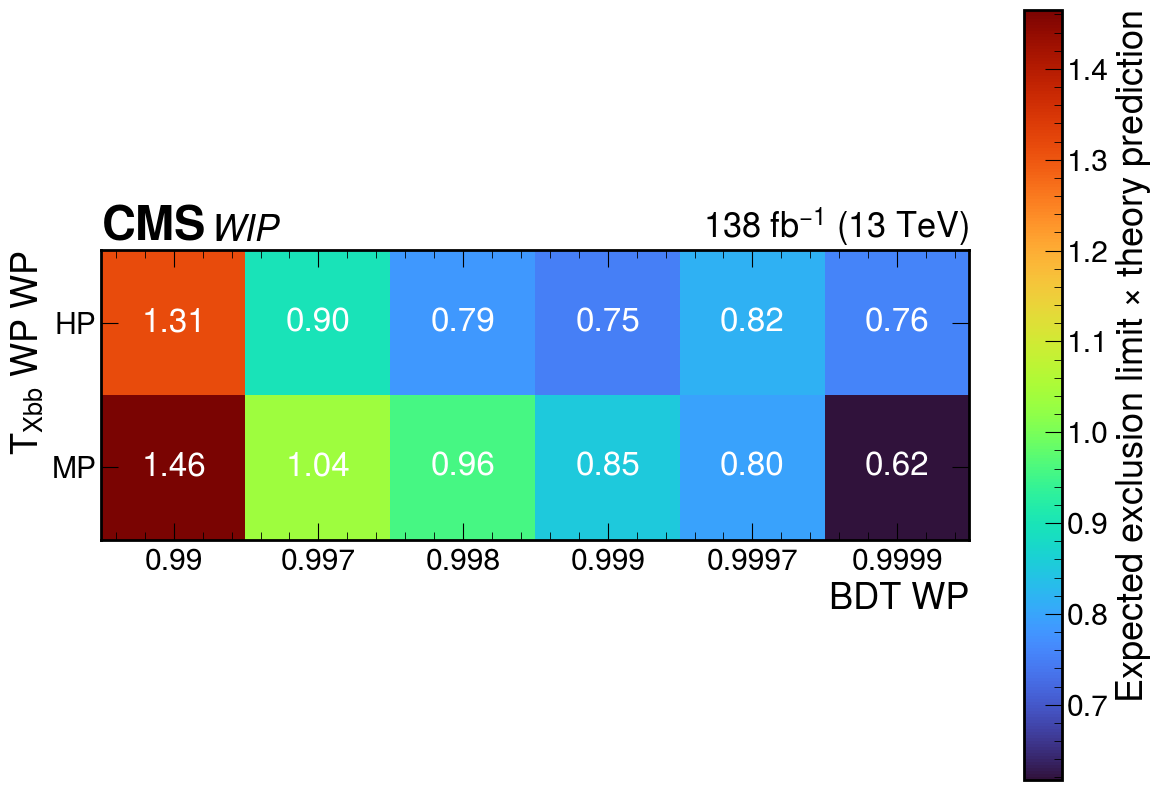

In [11]:
fig, axs = plt.subplots(
    len(limits),
    1,
    figsize=(len(scan2_wps) * len(scan1_wps) + len(scan1_wps), 10 * len(limits)),
    gridspec_kw={"hspace": 0.4},
)
for i, (sample, lim) in enumerate(limits.items()):
    ax = axs if len(scan_samples) == 1 else axs[i]
    plot_limits(ax, lim["50.0"], sample, 0.8)

plt.savefig(f"{plot_dir}/limscan.pdf", bbox_inches="tight")
plt.show()